In [1]:
## widen the cell width
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
from util import *
from models import *
from prime import get_primes
from cfg import get_cfg
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm as tqdm_normal
%matplotlib inline

In [3]:
d = 12
k = 7
M = 50000
N = 20
T = 25000
SEED = 4519
# 619 3019 1009 119 419 719 1319 4001 911 811 1109 4691

feature_bound = 1.
mapping_bound = 1.
param_bound = 1.

In [4]:
seeds = get_primes(start=200, end=6000)
print(seeds)

[211, 223, 227, 229, 233, 239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317, 331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419, 421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503, 509, 521, 523, 541, 547, 557, 563, 569, 571, 577, 587, 593, 599, 601, 607, 613, 617, 619, 631, 641, 643, 647, 653, 659, 661, 673, 677, 683, 691, 701, 709, 719, 727, 733, 739, 743, 751, 757, 761, 769, 773, 787, 797, 809, 811, 821, 823, 827, 829, 839, 853, 857, 859, 863, 877, 881, 883, 887, 907, 911, 919, 929, 937, 941, 947, 953, 967, 971, 977, 983, 991, 997, 1009, 1013, 1019, 1021, 1031, 1033, 1039, 1049, 1051, 1061, 1063, 1069, 1087, 1091, 1093, 1097, 1103, 1109, 1117, 1123, 1129, 1151, 1153, 1163, 1171, 1181, 1187, 1193, 1201, 1213, 1217, 1223, 1229, 1231, 1237, 1249, 1259, 1277, 1279, 1283, 1289, 1291, 1297, 1301, 1303, 1307, 1319, 1321, 1327, 1361, 1367, 1373, 1381, 1399, 1409, 1423, 1427, 1429, 1433, 1439, 1447, 1451, 1453, 1459, 1471,

seed = 211
alpha=0.0


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.20993, 0.28531]
alpha=0.001


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.20164, 0.28087]
alpha=0.01


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.33786, 0.26912]
alpha=0.05


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.39260, 0.31094]
alpha=0.1


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.28437, 0.29571]
Plot is Saved Completely!


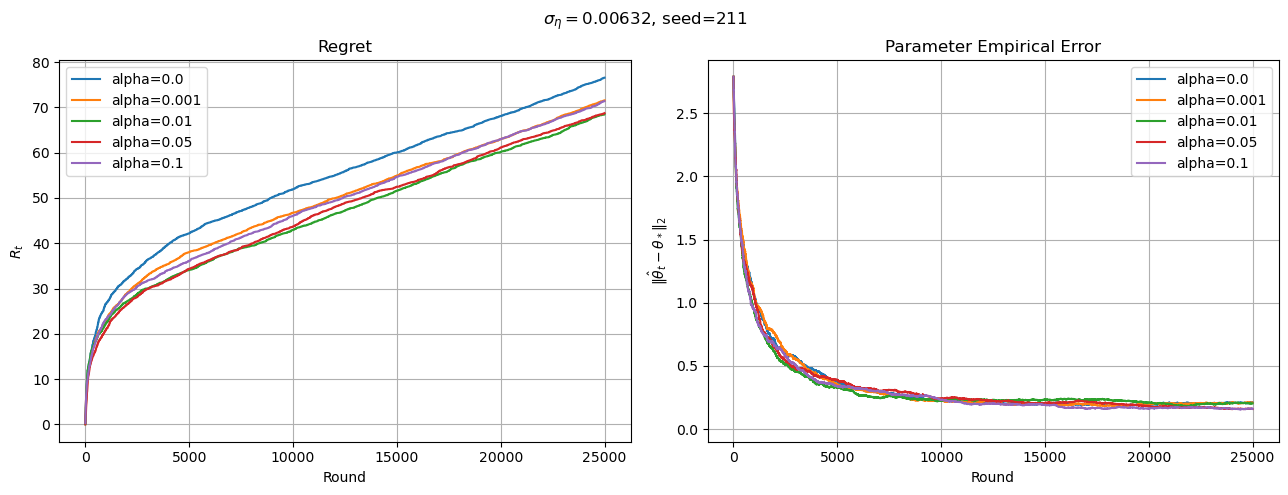

seed = 223
alpha=0.0


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.50717, 0.27366]
alpha=0.001


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.49564, 0.24799]


KeyboardInterrupt: 

In [5]:
reward_std = 0.1
context_std = 1 / np.sqrt(T)
alphas = [0., 0.001, 0.01, 0.05, 0.1]
trials = 1

for seed in seeds:
    print(f"seed = {seed}")
    Z = feature_sampler(dimension=k, feat_dist="gaussian", size=M, disjoint=True, 
                        bound=feature_bound, bound_method="scaling", random_state=seed)
    A = mapping_generator(latent_dim=k, obs_dim=d, distribution="uniform", 
                          upper_bound=mapping_bound, random_state=((seed*13)//3))
    true_mu = param_generator(dimension=k, distribution="uniform", disjoint=True, 
                              bound=param_bound, random_state=((seed*13)//3)+1)
    B = left_pseudo_inverse(A)
    true_theta = B.T @ true_mu
    
    result = dict()
    for alpha in alphas:
        print(f"alpha={alpha}")
        regret_container = np.zeros(trials, dtype=object)
        error_container = np.zeros(trials, dtype=object)
        for trial in range(trials):
            regrets = np.zeros(T)
            errors = np.zeros(T)
            agent = LinUCB(d=d, alpha=alpha, lbda=1.)
            for t in tqdm(range(T)):
                seed_ = seed + (100000 * trial) + t + int(1000000*alpha)
                idx = np.random.choice(np.arange(M), size=N, replace=False)
                latent_set = Z[idx, :]

                ## sample the context noise and generate the observable feature
                context_noise = subgaussian_noise(distribution="gaussian", size=(N*d), std=context_std, random_state=seed_).reshape(N, d)
                action_set = latent_set @ A.T + context_noise

                ## clipping
#                 for i in range(N):
#                     action = action_set[i, :]
#                     if l2norm(action) > feature_bound:
#                         action_set[i, :] *= (feature_bound / l2norm(action))

#                 ## scaling
#                 maxnorm = np.max([l2norm(action) for action in action_set])
#                 action_set *= (feature_bound / maxnorm)

                ## sample the reward noise and compute the reward
                reward_noise = subgaussian_noise(distribution="gaussian", size=N, std=reward_std, random_state=seed_+1)
                expected_reward = latent_set @ true_mu
                if t == 0:
                    print(f"Reward range: [{np.min(expected_reward):.5f}, {np.max(expected_reward):.5f}]")
                true_reward = expected_reward + reward_noise
                optimal_arm = np.argmax(expected_reward)
                optimal_reward = expected_reward[optimal_arm]

                ## choose the best action
                chosen_arm = agent.choose(action_set)
                chosen_reward = true_reward[chosen_arm]
                chosen_context = action_set[chosen_arm]

                ## compute the regret and the theta distances
                regrets[t] = optimal_reward - expected_reward[chosen_arm]
                errors[t] = l2norm(true_theta - agent.theta_hat)

                ## update the agent
                agent.update(x=chosen_context, r=chosen_reward)

            regret_container[trial] = np.cumsum(regrets)
            error_container[trial] = errors
        result[alpha] = (regret_container, error_container)
    
    NROWS, NCOLS = 1, 2
    title = r"$\sigma_\eta=$"
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(13, 5))

    for i in range(NROWS):
        for j in range(NCOLS):
            for key in result:
                item = result[key][j]
                ax[j].plot(np.mean(item, axis=0), label=f"alpha={key}")
                ax[j].set_xlabel("Round")
                if j == 0:
                    ax[j].set_ylabel(r"$R_t$")
                    ax[j].set_title("Regret")
                else:
                    ax[j].set_ylim(-0.1, None)
                    ax[j].set_ylabel(r"${\Vert \hat{\theta}_t - \theta_*\Vert}_2$")
                    ax[j].set_title(r"Parameter Empirical Error")
                ax[j].grid(True)
                ax[j].legend()

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    fig.suptitle(f"{title}{context_std:.5f}, seed={seed}")
    fname = f"seed_{seed}.png"
    save_plot(fig, path='seed_comparison', fname=fname)
    plt.show()

In [4]:
Z = feature_sampler(dimension=k, feat_dist="gaussian", size=M, disjoint=True, bound=feature_bound, 
                    bound_method="scaling", random_state=SEED)
print(f"Shape of the latent feature sets: {Z.shape}")
print(f"The first feature: {Z[0]}")
print(f"Maximum norm: {np.max([l2norm(latent) for latent in Z]):.5f}")

Shape of the latent feature sets: (50000, 7)
The first feature: [-0.00392194 -0.11666667  0.0533275   0.02859768  0.10037692 -0.09084898
  0.15682105]
Maximum norm: 1.00000


In [5]:
A = mapping_generator(latent_dim=k, obs_dim=d, distribution="uniform", upper_bound=mapping_bound, random_state=SEED)
print(f"Shape of the mapping: {A.shape}")
print(A)
print(f"Maximum singular value: {np.linalg.norm(A, 2):.5f}")
print(f"Singular values of A: {np.linalg.svd(A)[1]}")

Shape of the mapping: (12, 7)
[[-0.30275881 -0.01017773  0.15619005  0.29125532 -0.19509431  0.21555515
  -0.12932649]
 [ 0.07721522  0.21242195  0.23067463 -0.13495075  0.29730825  0.28722232
  -0.25178287]
 [-0.09002948  0.04835142  0.23273621  0.07813589  0.33048796 -0.01055657
  -0.08671152]
 [-0.03745835  0.32327257  0.3138335  -0.32111911  0.23298257  0.16726629
   0.14370707]
 [-0.1685825   0.09363786  0.30143681  0.19365633  0.14523336 -0.01808203
  -0.23140038]
 [-0.08015985 -0.29469627  0.26717103  0.0900951  -0.05340679  0.17050343
  -0.06322414]
 [ 0.29906643  0.28759998 -0.01634917  0.2265874   0.04788474 -0.11191457
   0.23527904]
 [-0.25829314  0.09821226 -0.22886681  0.01671502  0.29808231  0.00660692
  -0.02663642]
 [ 0.30178402 -0.26501688  0.17148719 -0.24251053 -0.32060832  0.18974897
   0.21507033]
 [ 0.2644351  -0.20364579  0.12361093  0.02650207  0.06091583  0.05939167
  -0.18713507]
 [ 0.08355876 -0.16689331 -0.10238743  0.28699675  0.16902639 -0.07023659
   0.2

In [8]:
B = left_pseudo_inverse(A)
print(f"Shape of B: {B.shape}")
print(B)
print(f"Maximum singular value: {np.linalg.norm(B, 2):.5f}")
print(f"Singular values of A: {np.linalg.svd(B)[1]}")

Shape of B: (7, 10)
[[-0.41996324  0.69355987 -0.1762755  -0.46281428 -0.24094511 -0.25192143
   0.86972724 -0.37795648  0.2668679   0.9203779 ]
 [ 0.51705243  0.69196694 -0.81262342  0.47277187  0.41819033 -1.23859308
   0.42971486 -0.72476199 -0.48835042 -0.56521565]
 [-0.16064589 -0.54808381  0.66279858  0.75484797  1.13908774  0.34854256
  -0.07554623 -1.1209476   0.20597291 -0.10399323]
 [ 0.91066718 -0.0841182   0.39099136 -0.71672276 -0.11078345  0.68945194
   1.46277681  0.55867508 -0.12546382  0.27170718]
 [-0.69118462  0.07736969  1.19061925  0.07215147 -0.49620517  0.85140684
   0.46852635  1.44005214 -0.07299895  0.50341006]
 [ 1.42618415  1.45232742 -0.43316914 -0.06670282 -1.44160433  0.74022082
   0.67175919  1.48647264  0.73087135  0.2153192 ]
 [ 0.04759613 -1.07304833  0.80741057  0.70840502 -0.8471534   1.08319023
   1.15502461  1.04808642  0.78325217 -0.6450852 ]]
Maximum singular value: 4.28564
Singular values of A: [4.28564434 3.11847279 2.00171923 1.82834461 1.228

In [9]:
true_mu = param_generator(dimension=k, distribution="uniform", disjoint=True, bound=param_bound, random_state=SEED+1)
print(f"True mu: {true_mu}")
print(f"Norm of the true mu: {l2norm(true_mu)}")

True mu: [ 5.60067690e-01  4.20507462e-01  4.33533405e-01 -1.32306448e-04
  2.93454928e-01  4.85042589e-01  1.28186533e-02]
Norm of the true mu: 1.0


In [10]:
true_theta = B.T @ true_mu
print(f"True theta: {true_theta}")
print(f"Norm of the true theta: {l2norm(true_theta)}")

True theta: [ 0.40198936  1.15520635 -0.00350931  0.26484371 -0.32095889  0.11185614
  1.11298813  0.15453681  0.3765439   0.47657406]
Norm of the true theta: 1.8202500960141776


In [11]:
reward_std = 0.1
context_std = 0.
alphas = [0., 0.25, 0.5, 0.75, 1.0]
trials = 1

In [12]:
result = dict()
for alpha in alphas:
    print(f"alpha={alpha}")
    regret_container = np.zeros(trials, dtype=object)
    error_container = np.zeros(trials, dtype=object)
    for trial in range(trials):
        regrets = np.zeros(T)
        errors = np.zeros(T)
        agent = LinUCB(d=d, alpha=alpha, lbda=1.)
        for t in tqdm(range(T)):
            seed = SEED + (100000 * trial) + t + int(10000000*alpha)
            idx = np.random.choice(np.arange(M), size=N, replace=False)
            latent_set = Z[idx, :]
            
            ## sample the context noise and generate the observable feature
            context_noise = subgaussian_noise(distribution="gaussian", size=(N*d), std=context_std, random_state=seed).reshape(N, d)
            action_set = latent_set @ A.T + context_noise
            
            ## clipping
            for i in range(N):
                action = action_set[i, :]
                if l2norm(action) > feature_bound:
                    action_set[i, :] *= (feature_bound / l2norm(action))

#             ## scaling
#             maxnorm = np.max([l2norm(action) for action in action_set])
#             action_set *= (feature_bound / maxnorm)
            
            ## sample the reward noise and compute the reward
            reward_noise = subgaussian_noise(distribution="gaussian", size=N, std=reward_std, random_state=seed)
            expected_reward = latent_set @ true_mu
            if t == 0:
                print(f"Reward range: [{np.min(expected_reward):.5f}, {np.max(expected_reward):.5f}]")
            true_reward = expected_reward + reward_noise
            optimal_arm = np.argmax(expected_reward)
            optimal_reward = expected_reward[optimal_arm]
            
            ## choose the best action
            chosen_arm = agent.choose(action_set)
            chosen_reward = true_reward[chosen_arm]
            chosen_context = action_set[chosen_arm]
            
            ## compute the regret and the theta distances
            regrets[t] = optimal_reward - expected_reward[chosen_arm]
            errors[t] = l2norm(true_theta - agent.theta_hat)
            
            ## update the agent
            agent.update(x=chosen_context, r=chosen_reward)
        
        regret_container[trial] = np.cumsum(regrets)
        error_container[trial] = errors
    result[alpha] = (regret_container, error_container)

alpha=0.0


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.26063, 0.25172]
alpha=0.25


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.40718, 0.24305]
alpha=0.5


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.27461, 0.35473]
alpha=0.75


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.21672, 0.31968]
alpha=1.0


  0%|          | 0/25000 [00:00<?, ?it/s]

Reward range: [-0.31226, 0.35362]


/home/sungwoopark/anaconda3/envs/main/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/sungwoopark/anaconda3/envs/main/lib/python3.10/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


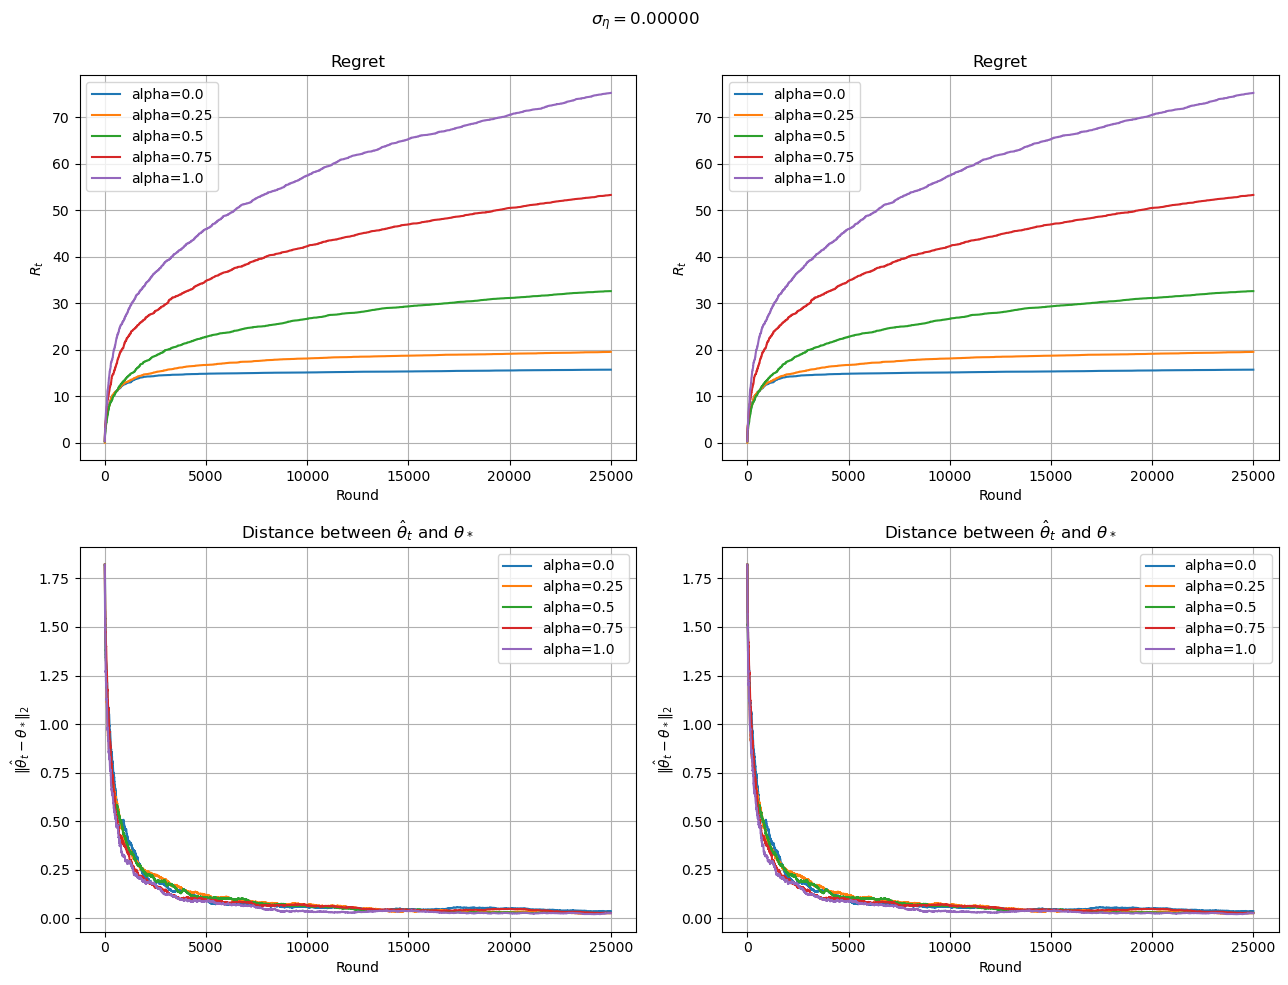

In [13]:
NROWS = NCOLS = 2
title = r"$\sigma_\eta=$"
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(13, 10))

for i in range(NROWS):
    for j in range(NCOLS):
        for key in result:
            item = result[key][i]
            if j == 0:
                ax[i][j].plot(np.mean(item, axis=0), label=f"alpha={key}")
            else:
                mean = np.mean(item, axis=0)
                std = np.std(item, axis=0, ddof=1)
                ax[i][j].plot(mean, label=f"alpha={key}")
                ax[i][j].fill_between(np.arange(T), mean-std, mean+std, alpha=0.2)
            ax[i][j].set_xlabel("Round")
            if i == 0:
                ax[i][j].set_ylabel(r"$R_t$")
                ax[i][j].set_title("Regret")
            else:
                ax[i][j].set_ylabel(r"${\Vert \hat{\theta}_t - \theta_*\Vert}_2$")
                ax[i][j].set_title(r"Distance between $\hat\theta_t$ and $\theta_*$")
            ax[i][j].grid(True)
            ax[i][j].legend()

fig.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle(f"{title}{context_std:.5f}")
fig.show()